## Problema do prof. Castelano

Diferential Equation:

$$
\frac{dx(t)}{dt} +\frac{x(t)}{\tau} - g(t) = 0
$$

with 
$$
g(t) = c_1 V(t) + c_2V^2(t)+ c_3V^3(t)+ c_4V^4(t)
\\
I(t) =[ G_0 +x(t) ] V(t),
\\
V(t) = -V_0t, for\; 0<t<t_1
$$
parameters to be determined 
$$G_0, c_1, c_2, c_3, c_4, \tau$$



## ..

In [13]:
#from sklearn import linear_model
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import torch  as tc



In [14]:
class SineActivation(nn.Module):
    def __init__(self): 
        super(SineActivation, self).__init__() 
    def forward(self, x):
        return tc.sin(x)
    
class Regressao_M(nn.Module):
    def __init__(self, neuronio, M, output=1, activation=nn.Mish(), creat_p=False, N_of_paramater=1):
        super().__init__()
        self.neuronio = neuronio
        self.M = M
        self.output = output
        self.creat_p = creat_p
        self.N_of_paramater = N_of_paramater

        # Lista para armazenar as camadas lineares
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neuronio)])
        self.hidden_layers.extend([nn.Linear(neuronio, neuronio) for _ in range(M-1)])
        
        # Última camada linear
        self.output_layer = nn.Linear(neuronio, output)

        # Função de ativação
        self.activation = activation

        if creat_p:
            #self.acceleration = nn.Parameter(tc.rand(N_of_paramater))
            self.acceleration = nn.Parameter(tc.ones(N_of_paramater)*2)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x


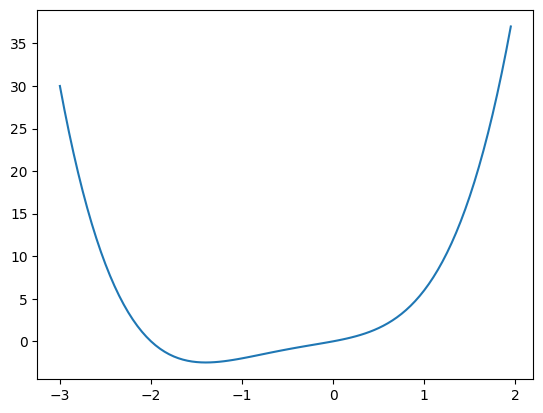

In [15]:
c1=2.0;c2=1.0;c3=2.0;c4=1.0
def g(V):
    return +c1*V+c2*V**2+c3*V**3+c4*V**4
x=np.zeros(100)
y=np.zeros(100)
for i in range(100):
    x[i]=-3+i/20
    y[i]=g(x[i])
plt.plot(x,y)
plt.show()
    




$$
Loss_{edo} = \frac{dx(t)}{dt} + x(t)  - g({V(t)})
$$

and   
$$
Loss_{data} =  data_{I(t)} - [ G_0 +x(t) ] data_{V(t)}
$$

The time range is $[0,2\pi/\omega]$

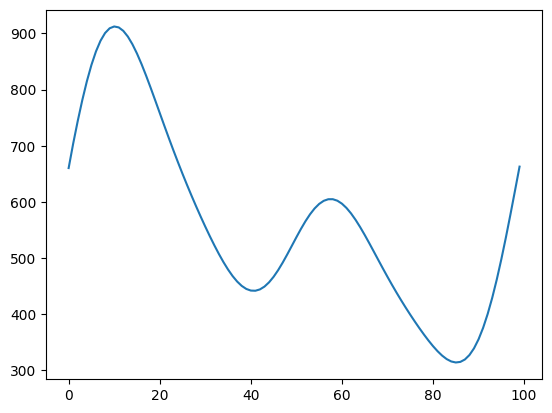

657.4918189970442 658.7320331012172


In [16]:
#generation of data
def numerical_solution(N,G0,c1,c2,c3,c4,tau,w,V0):
    def f(t,q,V):
        r=-q/tau+c1*V+c2*V**2+c3*V**3+c4*V**4
        return r
    def v(t,w):
        return V0*np.cos(w*t)
    Nc=4
    N1=Nc*(N)
    dt=2*np.pi/(N)/w

    n=np.zeros(N)
    I=np.zeros(N)
    V=np.zeros(N)
    t=np.zeros(N)
    n[0]=6
    I[0]=1
    t[0]=0
    V[0]=v(t[0],w)
    for j in range(Nc):
        if j>1:
            n[0]=n[-1]
            I[0]=I[-1]
        for i in range(N-1):
        #RK4
            t[i+1]=t[i]+dt
            k1=dt*f(t[i],n[i],v(t[i],w));
            k2=dt*f(t[i]+dt/2,n[i]+k1/2,v(t[i]+dt/2,w));
            k3=dt*f(t[i]+dt/2,n[i]+k2/2,v(t[i]+dt/2,w));
            k4=dt*f(t[i]+dt,n[i]+k3,v(t[i]+dt,w));
            n[i+1]=n[i]+(1.0/6.0)*(k1+k4+2.0*(k2+k3))
            I[i+1]=(G0+n[i+1])*v(t[i+1],w)
            V[i+1]=v(t[i+1],w)
    return t,I,V,n

N=100;G0=4;c1=1.0;c2=0.5;c3=2.0;c4=1.2;tau=2;w=1;V0=5.0;
time,current,potential,dn = numerical_solution(N,G0,c1,c2,c3,c4,tau,w,V0)
   
# plt.plot(time,dn)
plt.plot(current/potential)
plt.show()
print(dn[0],dn[-1])


# Aprendendo os parametros a, b, C_1 e C_2

In [20]:
def traino(lr_,neuronio_,camadas,fun_activation,epochs=1000,device_="cpu",G0=4,c1=1.0,c2=0.5,c3=2.0,c4=1.2,tau=2,w=1,V0=5.0):
    # Criando os dados de treino
    N=100;
    time,current,potential,DN = numerical_solution(N,G0,c1,c2,c3,c4,tau,w,V0)
    
    t_train = tc.tensor(time,requires_grad=True,dtype=tc.float,device=device_).reshape(-1,1)
    I_max=current.max()
    V_max=potential.max()
    
    
    I_data  = tc.tensor(current/I_max,dtype=tc.float,device=device_).reshape(-1,1)
    V_data  = tc.tensor(potential/V_max,dtype=tc.float,device=device_).reshape(-1,1)
    x_data  = tc.tensor(current/potential,dtype=tc.float,device=device_).reshape(-1,1)

    # criando o modelo

    model = Regressao_M(neuronio = neuronio_,M=camadas,output=1,activation=fun_activation,creat_p = True,N_of_paramater = 6)
    opt = tc.optim.Adam(params=model.parameters(),lr=lr_,betas=(0.9,0.999))

    # mando a rede nrual para GPU/cpu
    model.to(device_)

    LOSS = []
    LOSS2 = []
    for _ in range(epochs):
        model.train()
        x_preds = model(t_train)
        a_,C_1,C_2,C_3,C_4,tau_ = model.acceleration
#         a_,C_1,C_2 = model.acceleration
        
#       ###########################################################################
        # Derivando
        dx_dt = tc.autograd.grad(x_preds,t_train, grad_outputs=tc.ones_like(x_preds), create_graph=True,retain_graph=True)[0]
        # Edo
        V_d=V_data*V_max
        loss_ode_dydt = tc.mean( abs(dx_dt + x_preds/tau_ -C_1*V_d - C_2*(V_d)**2-C_3*V_d**3 - C_4*(V_d)**4)) # d
        # Usando os dado experimentais
#         loss_data = tc.mean(abs(I_data*I_max - (a_ + x_preds)*V_d ) )
        loss_data = tc.mean(abs(x_preds+a_-x_data))
        
        loss = 0.001*(loss_ode_dydt + loss_data)
        ############################################################################
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
        LOSS.append(loss_ode_dydt.cpu().detach().numpy())
        LOSS2.append(loss_data.cpu().detach().numpy())
    

    # Primeiro subplot
    solution = x_preds.detach().numpy()
    plt.plot(solution/solution.max(),"k.-")
    plt.plot((I_data/V_data).detach().numpy(),"r--")
    plt.show()

    plt.plot(LOSS,label="Treino")
    plt.plot(LOSS2,"r")
    plt.legend()
    plt.yscale('log')
    plt.show()
    # Segundo subplot a_,b_,C_1,C_2 = model.acceleration

#     a_,C_1,C_2 = model.acceleration.detach().numpy()
#     b_,C_1,C_2 = model.acceleration.detach().numpy()
    a_,C_1,C_2,C_3,C_4,tau_= model.acceleration.cpu().detach().numpy()
    time,current,potential,DX = numerical_solution(N,G0=a_,c1=C_1,c2=C_2,c3=C_3,c4=C_4,tau=tau_,w=w,V0=V0)
    plt.plot(potential,current,"r-",label='Predict')
    plt.plot((V_max*V_data).cpu(),(I_max*I_data).cpu(),"k--",label='Data')

    plt.ylabel('I(t)')
    plt.xlabel('V(t)')
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f"lr:{lr_} neuronio_ {neuronio_} camadas {camadas} fun_activation{fun_activation} ")
    print(f" Data : G0 = {G0}, c1 ={c1}, c2 = {c2} , c3 ={c3}, c4 = {c4} , tau = {tau} , w = {w}, V0 = {V0} ")
    print(f" Predicted : G0 = {a_}, c1 ={C_1}, c2 = {C_2} , c3 ={C_3}, c4 = {C_4} , tau = {tau_} , w = {w}, V0 = {V0}")

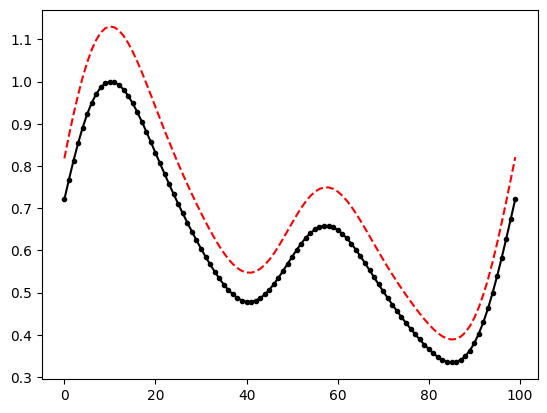

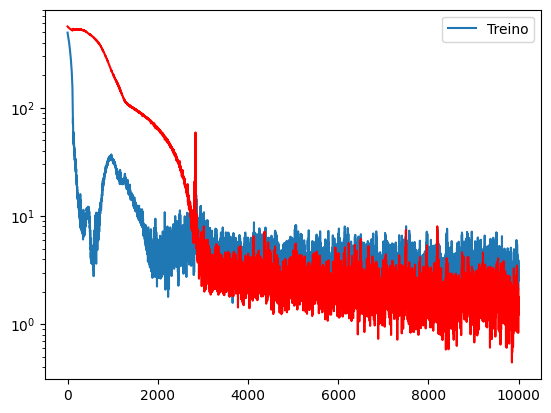

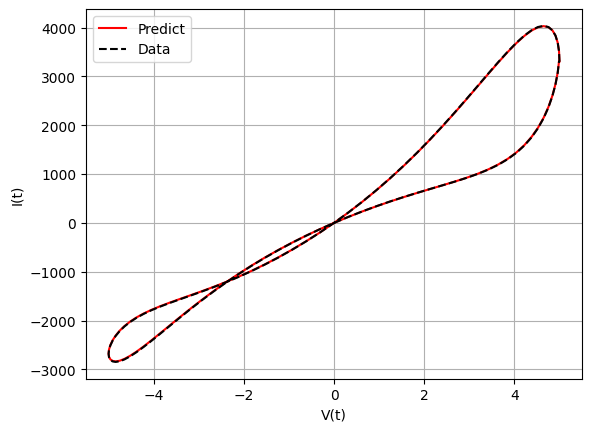

lr:0.01 neuronio_ 50 camadas 2 fun_activationSineActivation() 
 Data : G0 = 4, c1 =1.0, c2 = 0.5 , c3 =2.0, c4 = 1.2 , tau = 2 , w = 1, V0 = 5.0 
 Predicted : G0 = 15.893167495727539, c1 =2.0188586711883545, c2 = 0.7081268429756165 , c3 =1.955046534538269, c4 = 1.187635064125061 , tau = 1.9545319080352783 , w = 1, V0 = 5.0


In [18]:
traino(lr_=0.01,neuronio_=50,camadas=2,fun_activation=SineActivation(),epochs=10000)

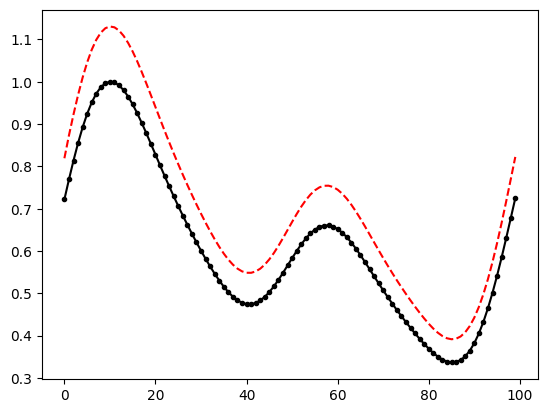

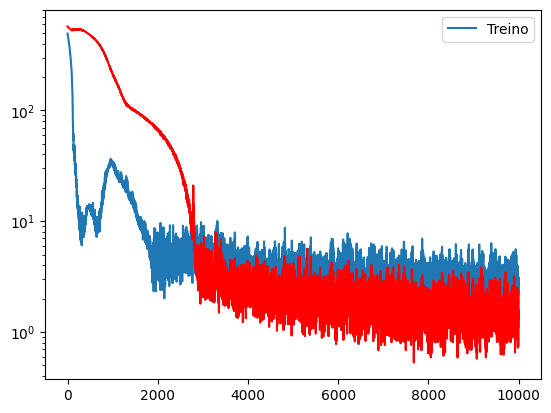

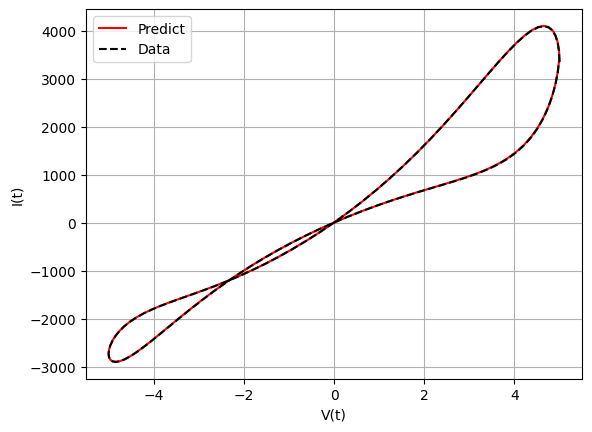

lr:0.01 neuronio_ 50 camadas 2 fun_activationSineActivation() 
 Data : G0 = 1, c1 =1.0, c2 = 1 , c3 =2.0, c4 = 1.2 , tau = 2 , w = 1, V0 = 5.0 
 Predicted : G0 = 15.647635459899902, c1 =1.6709307432174683, c2 = 0.7828000783920288 , c3 =1.974441647529602, c4 = 1.2071937322616577 , tau = 1.9564460515975952 , w = 1, V0 = 5.0


In [23]:
traino(lr_=0.01,neuronio_=50,camadas=2,fun_activation=SineActivation(),epochs=10000,device_="cpu",G0=1,c1=1.0,c2=1,c3=2.0,c4=1.2,tau=2,w=1,V0=5.0)

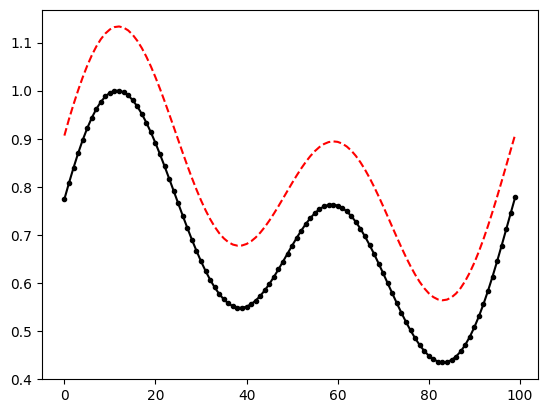

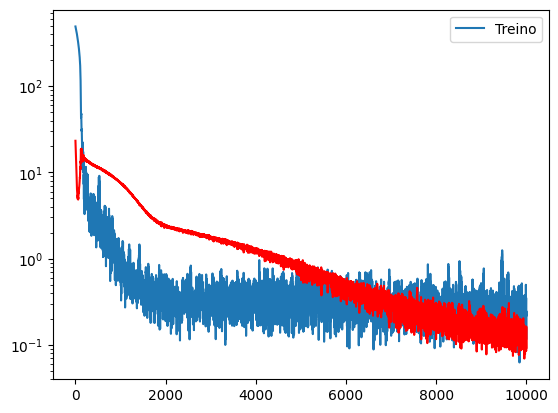

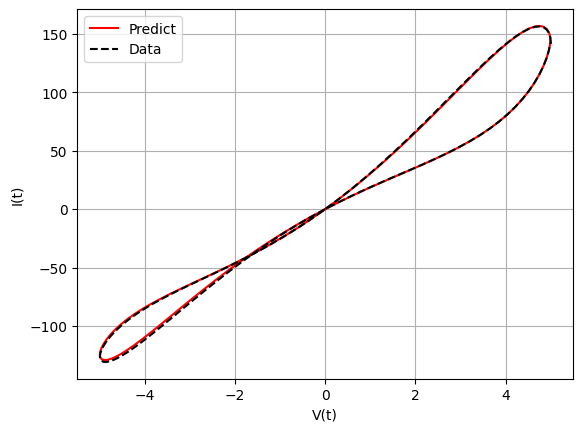

lr:0.01 neuronio_ 50 camadas 2 fun_activationSineActivation() 
 Data : G0 = 1, c1 =1.0, c2 = 1 , c3 =0, c4 = 0 , tau = 2 , w = 1, V0 = 5.0 
 Predicted : G0 = 3.972303867340088, c1 =1.0063683986663818, c2 = 0.8411071300506592 , c3 =0.0023524865973740816, c4 = 0.005676547065377235 , tau = 1.8386307954788208 , w = 1, V0 = 5.0


In [24]:
traino(lr_=0.01,neuronio_=50,camadas=2,fun_activation=SineActivation(),epochs=10000,device_="cpu",G0=1,c1=1.0,c2=1,c3=0,c4=0,tau=2,w=1,V0=5.0)

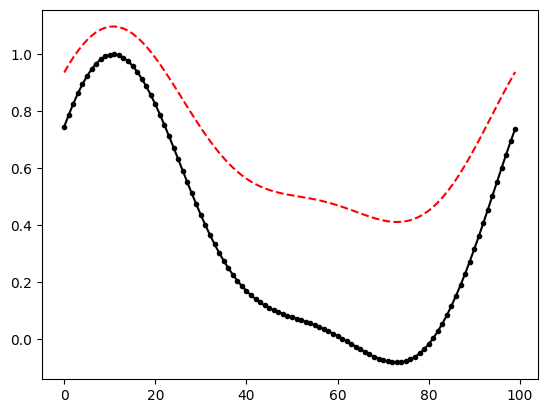

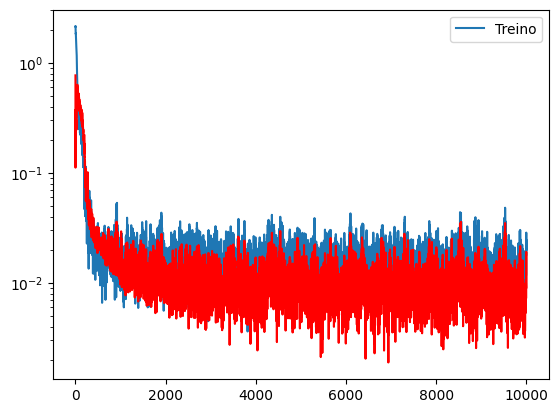

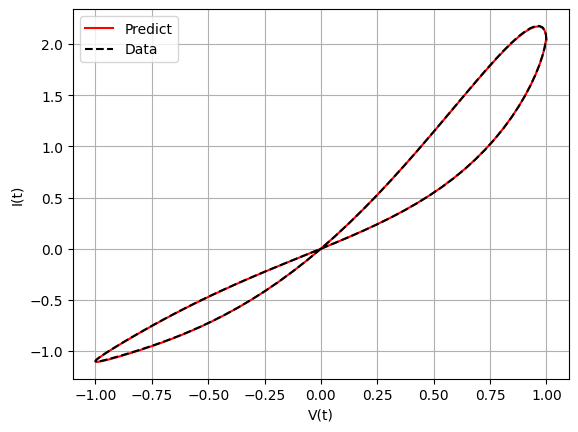

lr:0.01 neuronio_ 50 camadas 2 fun_activationSineActivation() 
 Data : G0 = 1, c1 =1.0, c2 = 1 , c3 =0, c4 = 0 , tau = 1 , w = 1, V0 = 1.0 
 Predicted : G0 = 0.9993243217468262, c1 =0.99690181016922, c2 = 1.0268458127975464 , c3 =-0.004604804329574108, c4 = -0.036798637360334396 , tau = 1.0039728879928589 , w = 1, V0 = 1.0


In [25]:
traino(lr_=0.01,neuronio_=50,camadas=2,fun_activation=SineActivation(),epochs=10000,device_="cpu",G0=1,c1=1.0,c2=1,c3=0,c4=0,tau=1,w=1,V0=1.0)